# Deep Learning & Vision

We explore **Deep Learning** applied to **computer vision**.

## Deep Neural Network

A **DNN** is a neural network with more than one hidden layer.  Here is one illustration:

![title](Figures/NN3.pdf)

In this example, the neurons perform a **nonlinear function** (e.g., a sigmoid or a ReLU).  In other networks, some layers implement kernel **convolutions**.  

The intuition for DNNs is that initial layers extract **features** from the data. For instance, a first convolution layer may extract edges in particular directions or detect the presence of some colors. A second layer may then detect if the edges form a particular patterm, such as a rectangle or an oval. Following layers then make **decisions** based on the presence of such features.  The decisions are not based on known rules. Instead, one uses SGD or some other optimization algorithm to adjust the weights and thresholds of the decision layers so that they result in the correct decisions most of the time.  The initial convolution layers may not change if they have proved useful in related applications.  Thus, SGD is often used to adjust only some of the layers. 

Here are some illustrations of kernels used in convolution layers:

![title](Figures/NN4.pdf)



Many DNNs also use **pooling layers** to reduce the amount of data.  The figure below illustrates the operations of such layers.

![title](Figures/NN5.pdf)

Here is a DNN that combines convolution layers, pooling layers, and fully connected ReLU layers:

![title](Figures/NN6.pdf)



## DNN and Object Recognition

The figure shows a DNN used to recognize articles of clothing.

![title](Figures/NN7.pdf)

The **flatten** layer converts the $28 \times 28$ pixel array into $784$ parallel bytes that are all connected to $128$ neurons. These $128$ neurons are connected to $10$ neurons that produce individual outputs.  The goal is to recognize which of $10$ categories (e.g., sneaker, coat, bag, t-shirt) the picture corresponds to.  Each output is the confidence that the object is of the corresponding category. The DNN is trained with Adam (see below) on $60,000$ labeled images and tested on $10,000$ other labeled images.  Here is how the code looks using **keras**.

![title](Figures/NN8.pdf)

The top instruction defines the DNN. The next instruction specifies the optimization algorithm (Adam) and the loss metric to minimize (cross-entropy, accuracy). The next instruction is the training of the network on the training data and its labels.  Next is the testing on the testing data. Finally, the code prints the accuracy measured on the testing data.


Here the link to run the clothing classifier on Colab: https://www.tensorflow.org/tutorials/keras/classification

**Adam** (adaptive moment estimation) is an optimization algorithm similar to SGD. The key innovation is the calculation of learning rates for the individual parameters by estimating the first and second moments of the partial derivatives. The intuition is that the step size should be smaller if the gradient estimates are very noisy, as measured by the ratio of the estimated mean value over the square root of the estimated second moment.
See https://arxiv.org/pdf/1412.6980.pdf for details.  

**Cross-entropy** is a measure of distance between two probability distributions $\mu$ and $\nu$ on a finite set $\{1, \ldots, N\}$. It is defined as 

$$H(\mu, \nu) = - \sum_{n=1}^N \mu(n) \log_2( \nu(n)).$$

As an example, assume that $\mu(m) = 1$ for some $m \in \{1, \ldots, N\}$.  Then $H(\mu, \nu) = - \log_2(\nu(m))$,
so that this loss is smaller if $\nu(m)$ is large.  Thus, if $\mu(m) = 1$ is the true probability (e.g., the item in the picture is $m$), the output $\nu$ of the classifier is better if it gives a higher probability to $m.$

As another example, say that the item in the picture has a probability $0.8$ of being a cat ($m = 1$) and $0.2$
of being a dog ($m=2$), then the loss of a classifier that comes up with the distribution $\nu$ is given by

$$H(\mu, \nu) = - 0.8 \log_2(\nu(1)) - 0.2 \log_2(\nu(2)).$$

We plot this loss as a function of $p = \nu(1)$:
As you see, this loss is minimized when $\nu$ matches $\mu$.

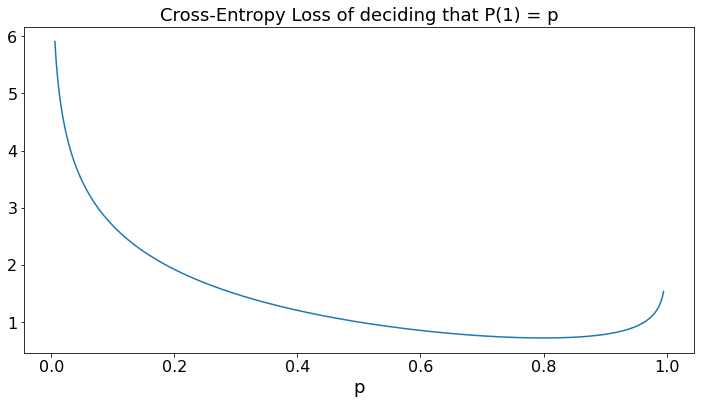

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
params = {'figure.figsize':(12,6), # These are plot parameters
         'xtick.labelsize': 16,
         'ytick.labelsize':16,
         'axes.titlesize':18,
         'axes.labelsize':18,
         'lines.markersize':4,
         'legend.fontsize': 20}
matplotlib.rcParams.update(params)
import math
X = [0.005 + 0.99*0.001*n for n in range(1,1001)]
Y = [-0.8*math.log(x,2)-0.2*math.log(1-x,2) for x in X]
plt.plot(X,Y)
plt.title('Cross-Entropy Loss of deciding that P(1) = p')
plt.xlabel('p')
plt.show()

A more intuitive measure is the KL divergence $KL(\mu, \nu)$ defined by

$$KL(\mu, \nu) = H(\mu, \nu) - H(\mu) = \sum_{n=1}^N \mu(n) \log_2\left( \frac{\mu(n)}{\nu(n)}\right)$$

where $H(\mu) = - \sum \mu(n) \log_2(\mu(n))$ is the entropy of $\mu$.  The entropy quantifies the uncertainty in an outcome with distribution $\mu$.  The KL divergence measures how unlikely it is for a random variable with distribution $\nu$ to behave as if its distribution were $\mu$.  In a sense, $KL(\mu, \nu)$ quantifies how
different $\nu$ is from $\mu$.  Thus, if the classifier produces the distribution $\nu$, its loss is measured by 
$KL(\mu, \nu)$.  Since $\mu$ is fixed, the loss is also measured by $H(\mu, \nu)$.

Here are two more words about the interpretration of $KL(\mu, \nu)$. Note that

$$ 2^{J \times KL(\mu, \nu)} = \Pi_{n=1}^N \left( \frac{\mu(n)}{\nu(n)}\right)^{J \mu(n)},$$

so that

$$2^{J \times KL(\mu, \nu)} = \frac{ \Pi_{n=1}^N \mu(n)^{J \mu(n)} }{\Pi_{n=1}^N \nu(n)^{J \mu(n)}}.$$

Consider the event that $J$ i.d.d. samples produce $J \times \mu(n)$ samples
with value $n$ for each $n$, as they should if their distribution is $\mu$.  The numerator in the fraction above is the probability that this occurs when
the samples have distribution $\mu$.  The denominator is the probability when the samples have distribution $\nu$.
Thus, the fraction indicates how unlikely it is for $\nu$ to produce the same numbers of the different sample
values one expects under $\mu$.  If the fraction is large, this is very unlikely.  Thus, $KL$ large means 
that $\nu$ would not behave like $\mu$.


## Face Mesh with DNN

The following code places a mesh on a face.  It is implemented as a DNN.

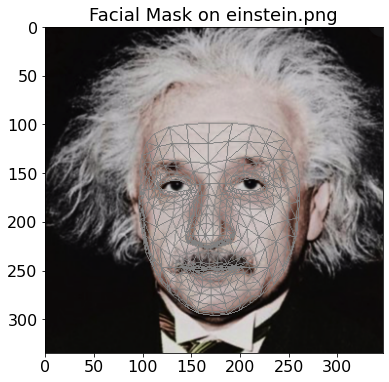

In [15]:
# IMPORTING LIBRARIES  --> pip install mediapipe
import cv2
import mediapipe as mp
from PIL import Image
import requests
from io import BytesIO
path = 'https://raw.githubusercontent.com/jeanwalrand/Notes_on_AI/main/'

def getImage(name):
    response = requests.get(path+name)
    im1 = Image.open(BytesIO(response.content))
    im2 = np.array(im1)
    return im2
    

# INITIALIZING OBJECTS
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh


image_name = 'einstein.png'
image = getImage(image_name)

drawing_spec = mp_drawing.DrawingSpec(thickness=5, circle_radius=2)


# DETECT THE FACE LANDMARKS
with mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5) as face_mesh:


    # Flip the image horizontally and convert the color space from BGR to RGB
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

    # To improve performance
    image.flags.writeable = False

    # Detect the face landmarks
    results = face_mesh.process(image)

    # To improve performance
    image.flags.writeable = True

    # Convert back to the BGR color space
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Draw the face mesh annotations on the image.
    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())

# Display the image
# Display the image
plt.imshow(image)
plt.title('Facial Mask on '+image_name)
plt.show()

## Object Detection with YOLO

This section discusses object recognition with **YOLO** (you only lookk once).  Here are some examples:

![title](Figures/NN10.pdf)

YOLO algorithm works using the following three techniques:
* Residual blocks
* Bounding box regression
* Intersection Over Union (IOU)

### Residual Blocks

First, the image is divided into various grids. Each grid has a dimension of S x S. 

![title](Figures/NN11.pdf)

### Bounding Box

Location, class $c$, confidence score (probability) $p_c$:

![title](Figures/NN12.pdf)

If center of an object falls into a cell, that cell is responsible for predicting the bounding box and its confidence score.

![title](Figures/NN12b.pdf)

### Intersection over union (IOU)

* Green = Actual
* Blue = Predicted
* Adjust weights so that Blue = Green!

IOU is a measure of the aggreement of the actual and predicted bounding boxes.  Using SGD, one increases IOU for a training set of images with bounding boxes.

![title](Figures/NN13.pdf)

![title](Figures/NN12c.pdf)


### The YOLO DNN

![title](Figures/NN14.pdf)

See https://arxiv.org/pdf/1506.02640v5.pdf for a discussion of YOLO.


## Object Tracking with Deep Sort

First, two examplse:

![title](Figures/track_pedestrians.gif)

![title](Figures/track_all.gif)

Deep Sort (for Simple Online Realtime Tracking) uses Yolo to get the bounding boxes with confidence measures and tracks the boxes with a Kalman filter.  

![title](Figures/NN15.pdf)

The Kalman filter predicts the future position of the box. The algorithm then compares the predicted position and the actual one in the subsequent frame using the IOU measure.  If the measure is too small, the algorithm discontinues the tracking of the object and considers that the box belongs to a new track.  The algorithm uses also the category and confidence to match the box to the tracked object.  See https://arxiv.org/abs/1703.07402
for details.  